## Курсовой проект по дисциплине "Библиотеки Python для Data Science"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, r2_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
import catboost as catb
import xgboost as xgb

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SUBMIT_DATASET_PATH = './sample_submission.csv'

In [3]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Признаки:

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Исследуем целевую переменную

In [5]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

В целом и без графика понятно распределение целевой переменной. Она принимает всего 2 значения.

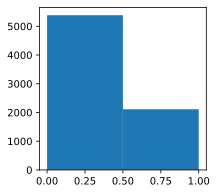

In [6]:
df_train['Credit Default'].hist(figsize=(3,3), bins=2, grid=False)

Видим что выборка не сбалансирована. Можно попробовать Undersampling и Oversampling или синтетические данные.

### Исследуем признаки

**Выделение признакового описания и целевой переменной**

In [7]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

CAT_FEATURE_NAMES = ["Home Ownership", "Years in current job", 
                     "Tax Liens", "Bankruptcies", "Number of Credit Problems", "Purpose", "Term"]

NUM_FEATURE_NAMES = ["Annual Income", "Number of Open Accounts", "Years of Credit History",
                     "Maximum Open Credit", "Months since last delinquent", "Current Loan Amount",
                     "Current Credit Balance", "Monthly Debt", "Credit Score"]

Посчитаем основные статистики по каждому признаку (минимальные, максимальные, средние значения)

In [8]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Посмотрим пропуски

In [9]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

В признаке "Months since last delinquent" нет больше 50% данных. Если данная переменная не сильно влияет на целевую, то уберем ее совсем. Если влиясние сильное, то заполним пропуски и возможно создадим новую dummy-переменную. 

**Посмотрим на распределение числовых переменных**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9660a83ca0>,
      dtype=object)

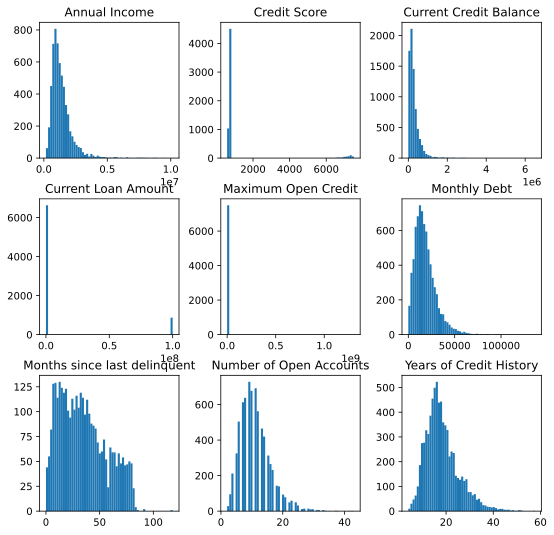

In [10]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(9,9), bins=60, grid=False)

#### Сравним с распределением на тесте

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96611da0a0>,
      dtype=object)

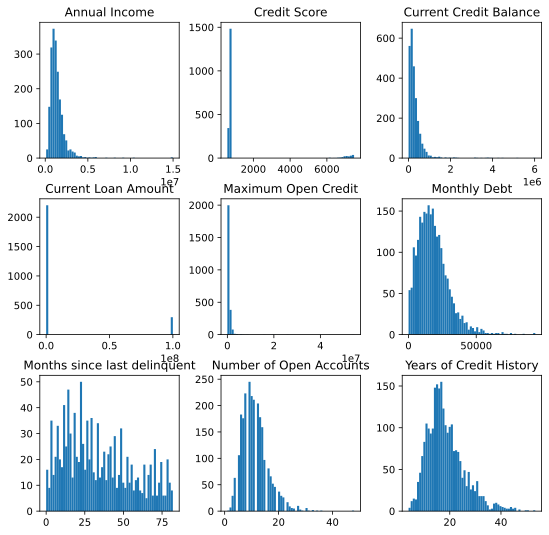

In [11]:
df_test[NUM_FEATURE_NAMES].hist(figsize=(9,9), bins=60, grid=False)

Судя по данным графикам значительные отличия в распределение есть по признакам "Months since last delinquent" и "Maximum Open Credit".
Сравним их детальней.

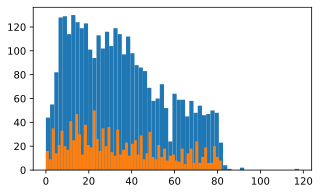

In [12]:
df_train["Months since last delinquent"].hist(figsize=(5,3), bins=60, grid=False)
df_test["Months since last delinquent"].hist(figsize=(5,3), bins=60, grid=False)

По этому признаку снова вопросы. В нем нехватает данны, да еще и данные на тренировочной выборке значительно отличаються от тестовой. Не стоит нам учить модель на этих данных

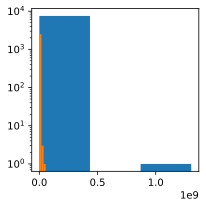

In [13]:
df_train["Maximum Open Credit"].hist(figsize=(3,3), bins=3, grid=False).set_yscale('log')
df_test["Maximum Open Credit"].hist(figsize=(3,3), bins=3, grid=False).set_yscale('log')

В "Maximum Open Credit" на тренировочной выборке поставим отсечку на 0.5 - все что выше считаем выбросом.

#### Построим матрицу корреляции признаков и целевой переменной

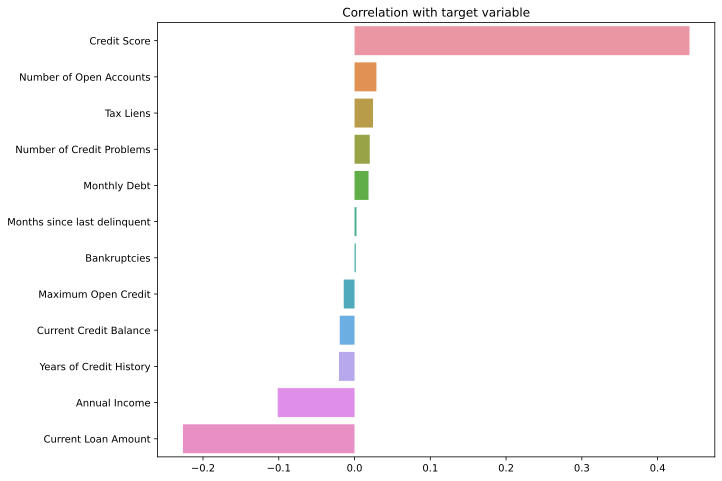

In [14]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Ну и последнее подтверждение того, что от "Months since last delinquent" мы избавляемся. Убираем в обоих выборках.
А вот "Annual income" и "Credit Score" - очень даже сильно влияют на целевую переменную. По этому пропусками в этих данных надо будет хорошо поработать.

In [15]:
df_train = df_train.drop("Months since last delinquent", axis = 1)
df_test = df_test.drop("Months since last delinquent", axis = 1)

#### Построим матрицу корреляций признаков

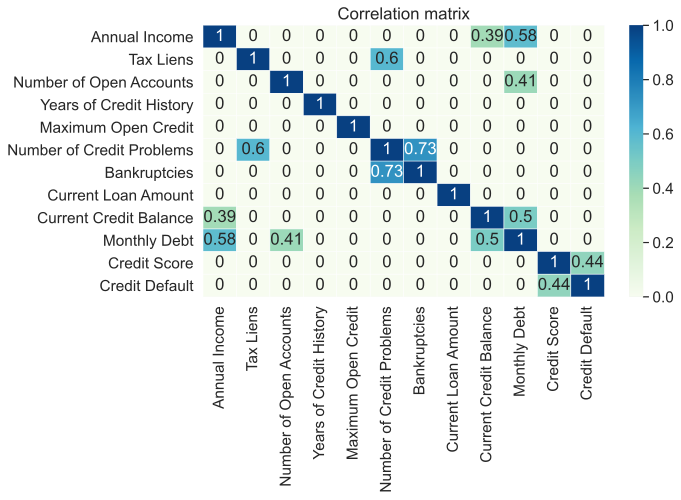

In [16]:
plt.figure(figsize=(9, 5))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Заполним пропуски

**Начнем с категориальных переменных.**

In [19]:
df_train[CAT_FEATURE_NAMES].isna().sum()[df_train.isna().sum() > 0]

Years in current job    371
Bankruptcies             14
dtype: int64

In [20]:
df_train['Years in current job'].fillna(0, inplace=True)
df_test['Years in current job'].fillna(0, inplace=True)
df_train['Bankruptcies'].fillna(0, inplace=True)
df_test['Bankruptcies'].fillna(0, inplace=True)

Проверим тип данных у наших категориальных перменных

In [21]:
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership                object
Years in current job          object
Tax Liens                    float64
Bankruptcies                 float64
Number of Credit Problems    float64
Purpose                       object
Term                          object
dtype: object

Заменим float64 на int

In [22]:
for col in CAT_FEATURE_NAMES:
    if df_train[col].dtype == 'float64':
        df_train[col] = df_train[col].astype('int')
        df_test[col] = df_test[col].astype('int')

df_test[CAT_FEATURE_NAMES].dtypes

Home Ownership               object
Years in current job         object
Tax Liens                     int64
Bankruptcies                  int64
Number of Credit Problems     int64
Purpose                      object
Term                         object
dtype: object

**Пропуски в количественных признаках.**

**Annual Income**

In [23]:
df_train['Annual Income'].median()

1168386.0

In [24]:
df_train['Annual Income NaN'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income NaN'] = 1
df_train[df_train['Annual Income NaN']==1].count()

Home Ownership               1557
Annual Income                   0
Years in current job         1557
Tax Liens                    1557
Number of Open Accounts      1557
Years of Credit History      1557
Maximum Open Credit          1557
Number of Credit Problems    1557
Bankruptcies                 1557
Purpose                      1557
Term                         1557
Current Loan Amount          1557
Current Credit Balance       1557
Monthly Debt                 1557
Credit Score                    0
Credit Default               1557
Annual Income NaN            1557
dtype: int64

In [27]:
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace = True)

In [29]:
df_train['Annual Income'].isna().sum()

0

Тоже самое делаем на df_test

In [36]:
df_test['Annual Income NaN'] = 0
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income NaN'] = 1
df_test[df_test['Annual Income NaN']==1].count()
df_test['Annual Income'].fillna(df_test['Annual Income'].median(), inplace = True)

In [37]:
df_test['Annual Income'].isna().sum()

0

**Credit Score**

In [31]:
df_train['Credit Score'].median()

731.0

In [32]:
df_train['Credit Score NaN'] = 0
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score NaN'] = 1
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace = True)
df_train['Credit Score'].isna().sum()

0

In [38]:
df_test['Credit Score NaN'] = 0
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score NaN'] = 1
df_test['Credit Score'].fillna(df_test['Credit Score'].median(), inplace = True)
df_test['Credit Score'].isna().sum()

0

In [39]:
df_test.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Annual Income NaN            0
Credit Score NaN             0
dtype: int64

### Разберемся с каждым из признаков

**Credit Score** - признак с самой большой корреляцией с целевой перменной.

Построим график распределения для признака Credit Score в зависимости от значения целевой переменной

In [ ]:
score_with_target = df_train[['Credit Score', TARGET_NAME]]
score = score_with_target['Credit Score']
score_target_0 = score[score_with_target[TARGET_NAME] == 0]
score_target_1 = score[score_with_target[TARGET_NAME] == 1]
plt.figure(figsize=(10, 4))
sns.kdeplot(score_target_0, shade=True, label='0', color='g')
sns.kdeplot(score_target_1, shade=True, label='1', color='r')
plt.title('Credit Score by Target')
plt.yscale('log')
plt.legend()
plt.show()

Видим что распределение для первой и второй категорий отличется и что разброс значений для признака Credit Score довольно большой. поэтому имеет смысл привести эти значения к одному порядку

In [ ]:
df_train.loc[df_train['Credit Score']>1000, 'Credit Score'] = df_train['Credit Score']/10
df_test.loc[df_test['Credit Score']>1000, 'Credit Score'] = df_test['Credit Score']/10

In [ ]:
score_with_target = df_train[['Credit Score', TARGET_NAME]]
score = score_with_target['Credit Score']
score_target_0 = score[score_with_target[TARGET_NAME] == 0]
score_target_1 = score[score_with_target[TARGET_NAME] == 1]
plt.figure(figsize=(10, 4))
sns.kdeplot(score_target_0, shade=True, label='0', color='g')
sns.kdeplot(score_target_1, shade=True, label='1', color='r')
plt.title('Credit Score by Target')
plt.legend()
plt.show()

После обработки распределения стали похожи.

**Current Loan Amount** - второй по корреляции признак.

Сначала разеберемся с выбросами

In [ ]:
df_train["Current Loan Amount"].hist(figsize=(5,3), bins=60, grid=False)
df_test["Current Loan Amount"].hist(figsize=(5,3), bins=60, grid=False)

In [ ]:
df_train["Current Loan Amount"].value_counts()

У нас явно есть выбросы. 870 значений 99999999. Заменим их на медиану

In [ ]:
median_loan_by_purpose = df_train.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'})
median_loan_by_purpose_test = df_test.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'})

In [ ]:
for purpose in median_loan_by_purpose['Purpose']:
    df_train.loc[(df_train['Current Loan Amount']==99999999) & (df_train['Purpose']==str(purpose)), 'Current Loan Amount'] = median_loan_by_purpose.loc[median_loan_by_purpose['Purpose']==purpose, 'Current Loan Amount']

for purpose in median_loan_by_purpose_test['Purpose']:
    df_test.loc[(df_test['Current Loan Amount']==99999999) & (df_test['Purpose']==str(purpose)), 'Current Loan Amount'] = median_loan_by_purpose_test.loc[median_loan_by_purpose_test['Purpose']==purpose, 'Current Loan Amount']

In [ ]:
df_train["Current Loan Amount"].value_counts()

In [ ]:
df_train["Current Loan Amount"].head()

Так же сравним его распределние с целевым

In [ ]:
loan_with_target = df_train[['Current Loan Amount', TARGET_NAME]]
loan = loan_with_target['Current Loan Amount']
loan_target_0 = loan[loan_with_target[TARGET_NAME] == 0]
loan_target_1 = loan[loan_with_target[TARGET_NAME] == 1]
plt.figure(figsize=(10, 4))
sns.kdeplot(loan_target_0, shade=True, label='0', color='b')
sns.kdeplot(loan_target_1, shade=True, label='1', color='g')
plt.legend()
plt.title('Current Loan Amount by Target')
plt.show()

**Annual Income**

In [ ]:
df_train["Annual Income"].hist(figsize=(5,3), bins=60, grid=False)
df_test["Annual Income"].hist(figsize=(5,3), bins=60, grid=False)

In [ ]:
df_train["Annual Income"].isna().sum()

Распределение на трейне и тесте похожи. Надо избавиться от выбросов.

Сначала приведем все выбросы по этому признаку к NaN. Будем отсекать значение выше 95 квантиля

In [ ]:
def preprocess_outlier(df, col, threshold):
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'Annual Income'
df_train = preprocess_outlier(df_train, feature_name, threshold=df_train['Annual Income'].quantile(0.95))
df_test = preprocess_outlier(df_test, feature_name, threshold=df_test['Annual Income'].quantile(0.95))

df_train[feature_name].isna().sum()

In [ ]:
df_train["Annual Income"].hist(figsize=(5,3), bins=60, grid=False)
df_test["Annual Income"].hist(figsize=(5,3), bins=60, grid=False)

Теперь заполним пропуски с помощью модели RandomForestRegressor.

In [ ]:
from sklearn.metrics import r2_score


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    
    
    model = RandomForestRegressor(n_estimators=100,
                                   max_depth=10,
                                  random_state=42,
                                  verbose=1)
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

RandomForest не работает с пропусками данных. По этому создаем набор фич без пропусков.

In [ ]:
NEW_NUM_FEATURE_NAMES = ["Annual Income", "Number of Open Accounts", "Years of Credit History",
                     "Maximum Open Credit", "Current Credit Balance",
                     "Monthly Debt"]

Делаем предсказание и заполнение на тренировочной выборке.

In [ ]:
%%time
annual_income_predictor, df_train[NEW_NUM_FEATURE_NAMES] = imputer_rfr(df_train[NEW_NUM_FEATURE_NAMES], 'Annual Income')

Делаем предсказание и заполнение на тестовой выборке.(оказывается там тоже есть пропуски)

In [ ]:
%%time
annual_income_predictor, df_test[NEW_NUM_FEATURE_NAMES] = imputer_rfr(df_test[NEW_NUM_FEATURE_NAMES], 'Annual Income')

Метрики такого обучения далеки от идеала. Модель явно переобучается. Но в данном случае пренебрегаем кач-вом предсказания, так как модель больше нигде нам не пригодится.

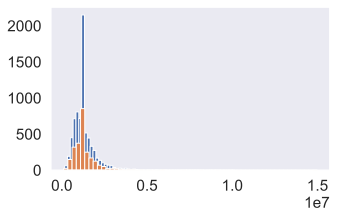

In [40]:
df_train["Annual Income"].hist(figsize=(5,3), bins=60, grid=False)
df_test["Annual Income"].hist(figsize=(5,3), bins=60, grid=False)

In [ ]:
df_train["Annual Income"].isna().sum()

**Home Ownership** - категориальный признак.

In [61]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

*Заменим значения* на dummy переменные 0,1,2 и 3

In [62]:
df_train['Home Ownership'] = df_train['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1', 'Own Home':'2', 'Have Mortgage':'3'}).astype(int)
df_test['Home Ownership'] = df_test['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1', 'Own Home':'2', 'Have Mortgage':'3'}).astype(int)

**Years in current job** - категориальный признак

In [56]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
0             371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Уменьшим количество показателей и приведем из в int для использования в XGBoost

In [57]:
df_train['Years in current job'] = df_train['Years in current job'].map({0:'0', '< 1 year':'0', '1 year':'1',
                                                                         '2 years':'1', '3 years':'1',
                                                                         '4 years':'2', '5 years':'2',
                                                                         '6 years':'2', '7 years':'2',
                                                                         '8 years':'2', '9 years':'3',
                                                                         '10+ years':'3'}).astype(int)
df_test['Years in current job'] = df_test['Years in current job'].map({0:'0', '< 1 year':'0', '1 year':'1',
                                                                       '2 years':'1', '3 years':'1',
                                                                       '4 years':'2', '5 years':'2',
                                                                       '6 years':'2', '7 years':'2',
                                                                       '8 years':'2', '9 years':'3',
                                                                       '10+ years':'3'}).astype(int)

In [58]:
df_train['Years in current job'].value_counts()

3    2591
2    2146
1    1829
0     934
Name: Years in current job, dtype: int64

**Tax Liens** - больше 90% значений лежат на значений "0,0". Предлагаю сделать из этой перменной категориальную и поменять значения отличные от 0 на еденицу 

In [ ]:
df_train['Tax Liens'].value_counts()

In [ ]:
df_train.loc[df_train['Tax Liens'] > 0, 'Tax Liens'] = 1
df_test.loc[df_test['Tax Liens'] > 0, 'Tax Liens'] = 1

In [ ]:
df_train['Tax Liens'].value_counts()

In [ ]:
df_train["Years of Credit History"].hist(figsize=(5,3), bins=60, grid=False)
df_test["Years of Credit History"].hist(figsize=(5,3), bins=60, grid=False)

**Purpose** - категориальный признак

In [60]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [65]:
df_train = df_train.drop('Purpose', axis=1)
df_test = df_test.drop('Purpose', axis=1)

In [ ]:
df_train['Purpose'] = df_train['Purpose'].map({'debt consolidation':'0', 'other':'1', 'major purchase':'1',
                                                                         'take a trip':'1', 'buy house':'1', 'small business':'1',
                                                                         'wedding':'1', 'moving':'1', 'educational expenses':'1',
                                                                         'vacation':'1','renewable energy':'1','medical bills':'5',
                                                                         'home improvements':'2','business loan':'3', 'buy a car':'4'}).astype(int)
df_test['Purpose'] = df_test['Purpose'].map({'debt consolidation':'0', 'other':'1', 'major purchase':'1',
                                                                         'take a trip':'1', 'buy house':'1', 'small business':'1',
                                                                         'wedding':'1', 'moving':'1', 'educational expenses':'1',
                                                                         'vacation':'1','renewable energy':'1','medical bills':'5',
                                                                         'home improvements':'2','business loan':'3', 'buy a car':'4'}).astype(int)

**Term** - категориальный признак

In [41]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [42]:
df_train['Term'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)
df_test['Term'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [66]:
df_train.dtypes

Home Ownership                 int64
Annual Income                float64
Years in current job           int64
Tax Liens                      int64
Number of Open Accounts      float64
Years of Credit History      float64
Maximum Open Credit          float64
Number of Credit Problems      int64
Bankruptcies                   int64
Term                           int64
Current Loan Amount          float64
Current Credit Balance       float64
Monthly Debt                 float64
Credit Score                 float64
Credit Default                 int64
Annual Income NaN              int64
Credit Score NaN               int64
dtype: object

### Разделим df_train на тренировочную и тестовую выборку

In [67]:
y = df_train[TARGET_NAME]
y.shape

(7500,)

In [68]:
df = df_train.drop(TARGET_NAME, axis = 1)

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size = 0.3,
                                                        shuffle=True,
                                                        random_state=42)

In [70]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5250, 16), (2250, 16), (5250,), (2250,))

## Обучаем модели

In [47]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [48]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [49]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (10, 4))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [50]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Обучим модель catboost со следующими параметрами:

iterations=100 - количество деревьев \
nan_mode='Min' - замена пропусков минимальным значением (меньше любого значения в столбце)\
cat_features=cat_feature_names - список категориальных переменных\
eval_set=(X_valid, y_valid) - данные для валидации\
Сделаем предсказания (получим метки классов). Проверим их точность по метрикам precision, recall, f1-score и accuracy

In [71]:
df_train.dtypes

Home Ownership                 int64
Annual Income                float64
Years in current job           int64
Tax Liens                      int64
Number of Open Accounts      float64
Years of Credit History      float64
Maximum Open Credit          float64
Number of Credit Problems      int64
Bankruptcies                   int64
Term                           int64
Current Loan Amount          float64
Current Credit Balance       float64
Monthly Debt                 float64
Credit Score                 float64
Credit Default                 int64
Annual Income NaN              int64
Credit Score NaN               int64
dtype: object

In [75]:
NEW_CAT_FEATURE_NAMES = ["Home Ownership", "Years in current job", 
                     "Tax Liens", "Bankruptcies", "Number of Credit Problems", "Term"]

In [76]:
catboost = catb.CatBoostClassifier(iterations=100, 
                                   nan_mode='Min', 
                                   silent=True, 
                                   random_state=42)
catboost.fit(X_train, y_train, 
             cat_features=NEW_CAT_FEATURE_NAMES, 
             eval_set=(X_valid, y_valid)
            )

y_train_pred = catboost.predict(X_train)
y_valid_pred = catboost.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      3795
           1       0.87      0.32      0.47      1455

    accuracy                           0.80      5250
   macro avg       0.83      0.65      0.67      5250
weighted avg       0.81      0.80      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1592
           1       0.81      0.30      0.44       658

    accuracy                           0.77      2250
   macro avg       0.79      0.63      0.65      2250
weighted avg       0.78      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1547   45
1                462  196


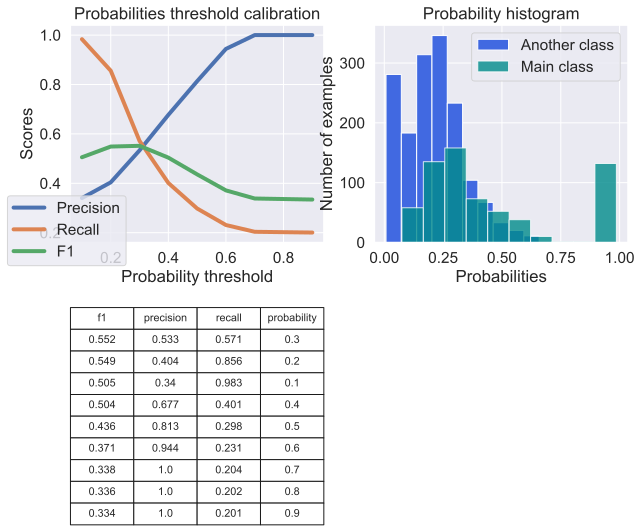

In [77]:
y_valid_proba = catboost.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_proba, y_valid)

Порог вероятности на отложенной выборке примерно 0.3. Перепишем метки классов в соответствии с найденным порогом и снова проверим точность предсказания

In [78]:
y_valid_pred = np.array(y_valid_proba > 0.31, dtype=int)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      3795
           1       0.87      0.32      0.47      1455

    accuracy                           0.80      5250
   macro avg       0.83      0.65      0.67      5250
weighted avg       0.81      0.80      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1592
           1       0.54      0.54      0.54       658

    accuracy                           0.73      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1293  299
1                303  355


На test все три метрики больше 0.5 - это нас устраивет

Сохраним этот вариант

In [ ]:
catboost.fit(df_train, y, 
             cat_features=CAT_FEATURE_NAMES)

y_test_pred = catboost.predict_proba(df_test)[:, 1]
y_test_pred = np.array(y_test_pred > 0.31, dtype=int)

submit['Credit Default'] = y_test_pred
submit.to_csv('catboost_predictions2.csv', index=False)

### XGBoost

In [80]:
X_train.dtypes

Home Ownership                 int64
Annual Income                float64
Years in current job           int64
Tax Liens                      int64
Number of Open Accounts      float64
Years of Credit History      float64
Maximum Open Credit          float64
Number of Credit Problems      int64
Bankruptcies                   int64
Term                           int64
Current Loan Amount          float64
Current Credit Balance       float64
Monthly Debt                 float64
Credit Score                 float64
Annual Income NaN              int64
Credit Score NaN               int64
dtype: object

In [81]:
xgboost = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=5)
xgboost.fit(X_train, y_train)


y_train_pred = xgboost.predict(X_train)
y_valid_pred = xgboost.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

[17:28:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      3795
           1       0.89      0.25      0.39      1455

    accuracy                           0.78      5250
   macro avg       0.83      0.62      0.63      5250
weighted avg       0.81      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1592
           1       0.87      0.27      0.41       658

    accuracy                           0.77      2250
   macro avg       0.82      0.62      0.63      2250
weighted avg       0.80    

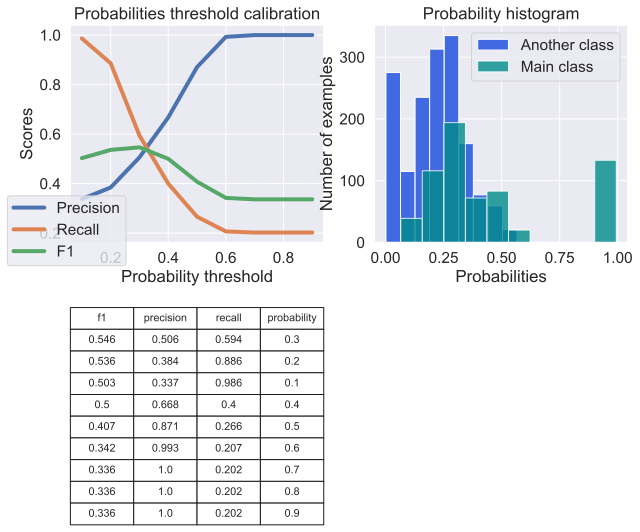

In [82]:
y_valid_proba = xgboost.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_proba, y_valid)

In [83]:
y_valid_pred = np.array(y_valid_proba > 0.33, dtype=int)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      3795
           1       0.89      0.25      0.39      1455

    accuracy                           0.78      5250
   macro avg       0.83      0.62      0.63      5250
weighted avg       0.81      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1592
           1       0.55      0.49      0.52       658

    accuracy                           0.73      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1327  265
1                334  324


### Вывод:

**С текущий обработкой признаков лучший результат дает Catboost. В среднем 0,55.**